# Exploration and explotation methods

This notebook contains implementation and demonstration of various reinforcement learning methods focused on the exploration-exploitation trade-off problem.

1. Epsilon-Greedy
2. Optimistic Initial Values
3. Upper Confidence Bound (UCB1)
4. Thompson Sampling
5. Thompson Sampling with Gaussian Reward

In [1]:
# Libraries needed
import random as rnd
from matplotlib import pyplot as plt
from math import log
import numpy as np
from scipy.stats import beta

In [2]:
# Plot methods
def plot_bandit_balance(bandits):
    names = [i.n for i in bandits]
    n_pulls = [i.n_pulls for i in bandits]
    colors = ['#453C67', '#5B8FB9', '#E94560']
    
    fig = plt.figure(figsize=(5, 2))
    ax = fig.add_axes([0,0,1,1])
    if len(n_pulls) > 1:
        bars = ax.bar(names, n_pulls, color=colors)
    else:
        bars = ax.bar(names, n_pulls)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')
    
    ax.set_xlabel('Bandit machine')
    ax.set_ylabel('Number of pulls')
    ax.set_title('Number of pulls by bandit')
    plt.show()

def plot_bayesian_distributions(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.cumulated_reward+1, b.cumulated_failure+1)
        plt.plot(x, y, label=f"real p: {b.p:.2f}, win rate = {b.cumulated_reward}/{b.n_pulls}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()


def plot_cumulative_rewards(names, bandits_rewards):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes([0,0,1,1])
    
    for name, data in zip(names, bandits_rewards):
        cumulative_sum = [sum(data[:i+1]) for i in range(len(data))]
        ax.plot(range(len(data)), cumulative_sum, label=name)
        
    ax.legend()
    ax.set_xlabel('Pulls')
    ax.set_ylabel('Reward')
    ax.set_title('Rewards comparison for each machine')
    plt.show()

## The multiarmed bandit problem

A multi-armed bandit is a problem in reinforcement learning where an agent must choose between multiple options (the "arms" of the "bandit"), with each option having a potentially different reward. The agent must balance exploration (trying different options to learn more about their rewards) and exploitation (choosing the option with the highest known reward) in order to maximize its overall reward.

**Class in Python to simulate a bandit machine**

In [3]:
class bandit_machine:
    """
    class to generate a bandit machine model
    """
    def __init__(self, name: str, probability: float, intial_mean: int = 0, save_history: bool = False):
        """
        Contructor to initialize a bandit machine
        :var name: name of the machine
        :var probability: probabilty to gain a reward
        :var initial_mean: initial sample mean of the machine
        :var save_history: if True saves the sample mean of every result (memory consuming)
        """
        self.n = name                               # Name of the machine
        self.p = probability                        # Probability to gain a reward
        self.n_pulls = 0                            # Number of times the arm was pulled
        self.cumulated_reward = 0                   # Total reward
        self.cumulated_failure = 0                  # Total failures
        self.sample_mean = intial_mean              # Mean from the rewards given
        self.sample_mean_history = [intial_mean]    # Saves a history of all the sample means

        # Check the initial_mean
        if intial_mean > 0:
            self.n_pulls = 1

    def pull(self) -> int:
        """
        Method to simulate a result after pulling the arm from the machine
        :return: 1 if you got a reward, 0 if you didn't
        """
        reward = int(rnd.random() < self.p)
        self._update_parameters(reward)
        return reward

    def _update_parameters(self, reward):
        """
        Method to update all the bandit parameters after pulling the arm
        """
        self.n_pulls += 1
        self.cumulated_reward += reward
        self.cumulated_failure += 1 - reward
        self.sample_mean = (self.sample_mean * (self.n_pulls-1) + reward)/self.n_pulls
        self.sample_mean_history.append(self.sample_mean)

    def get_data(self):
        """
        Method to get all the history data from the bandit machine
        """
        msg = f"""
        [{self.n} ({self.p})]
          - Arm pulled: {self.n_pulls}
          - Sample mean: {self.sample_mean}
          - Cumulated reward: {self.cumulated_reward}
          - Cumulated failures: {self.cumulated_failure}
        """
        print(msg)
        self._plot_sample_mean_graph()

    def _plot_sample_mean_graph(self):
        x_values = range(len(self.sample_mean_history))
        y_values = self.sample_mean_history
        plt.plot(x_values, y_values, '-')
        plt.xlabel("Iterations")
        plt.ylabel("Estimated mean")
        plt.title(f"{self.n} ({self.p})")
        plt.show()

**Creating the bandit machines**

For the following scripts, we are going to test various reinforcement learning methods on three different bandit machines. Each machine has a distinct probability of giving a reward, with one having a probability of 0.2, another 0.5, and the last one 0.75.

In [4]:
# Define the initial parameters for the three bandit machines
initial_params = {'bandit_l': 0.25, 'bandit_m': 0.5, 'bandit_h': 0.75}

# Create the bandits
bandits_test = [bandit_machine(name=n, probability=p) for n, p in initial_params.items()]

**Testing the bandit machines**

In [5]:
# Test the bandit machines
n_test_pulls = 10
samples = [[bandit.pull() for i in range(n_test_pulls)] for bandit in bandits_test]

# Print out the results
for bandit, sample in zip(bandits_test, samples):
    print(f"The {bandit.n} got this results: {sample}. Estimated mean: {bandit.sample_mean}/{bandit.p}")

The bandit_l got this results: [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]. Estimated mean: 0.2/0.25
The bandit_m got this results: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1]. Estimated mean: 0.4/0.5
The bandit_h got this results: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]. Estimated mean: 0.9/0.75


## 1. Epsilon Greedy method

Epsilon-Greedy method is an algorithm that balances exploration and exploitation by choosing a random action with a small probability and the greedy action with a high probability, to gather information about the environment and make better decisions over time.

**Experiment:**

In [6]:
# Creating the bandits for this experiment
bandits_greedy = [bandit_machine(name=n, probability=p, save_history=True) for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500             # Number of total pulls allowed
epsilon = 0.1                   # Epsilon is the probability to do a random action and explore
total_reward_greedy = 0         # Total reward of the experiment
reward_history_greedy = [0]     # Reward history of the experiment

# Run the experiments
for i in range(n_experiments):
    # Choose the bandit based on the epsilon parameter
    if rnd.random() >= 0.1:
        # Choose the best machine and exploit
        bandits_sample_mean = [m.sample_mean for m in bandits_greedy]
        j = np.argmax(bandits_sample_mean)
    else:
        # Choose a random machine and explore
        j = rnd.randint(0,len(bandits_greedy)-1)
    
    # Pull the arm of the selected machine
    total_reward_greedy += bandits_greedy[j].pull()
    reward_history_greedy.append(total_reward_greedy)

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 37
          - Sample mean: 0.35135135135135137
          - Cumulated reward: 13
          - Cumulated failures: 24
        


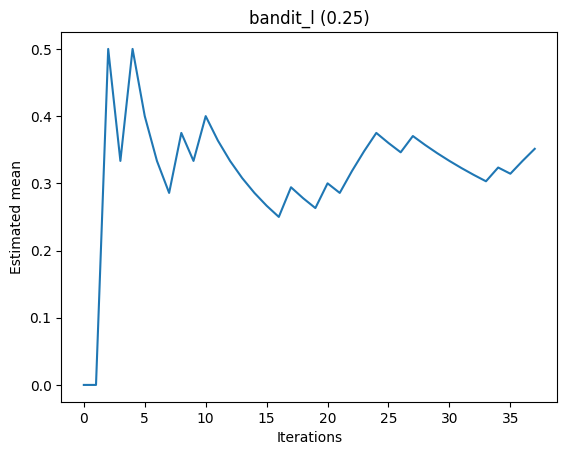


        [bandit_m (0.5)]
          - Arm pulled: 23
          - Sample mean: 0.21739130434782608
          - Cumulated reward: 5
          - Cumulated failures: 18
        


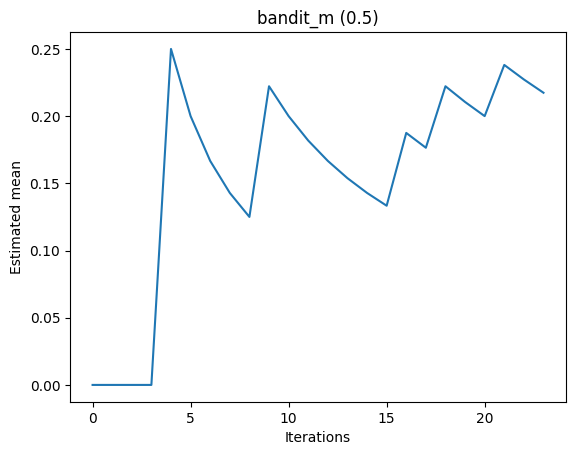


        [bandit_h (0.75)]
          - Arm pulled: 440
          - Sample mean: 0.7295454545454548
          - Cumulated reward: 321
          - Cumulated failures: 119
        


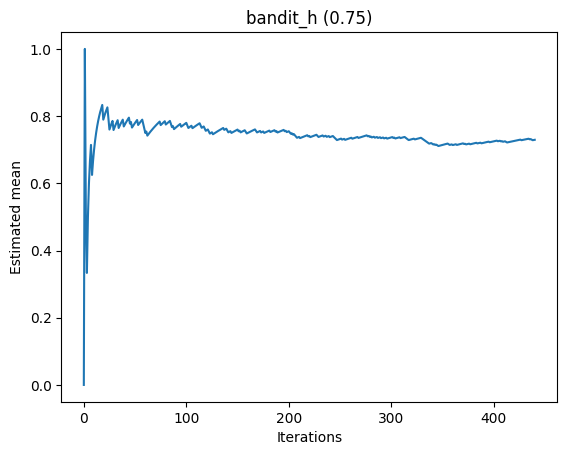

The total reward is 339 points in 500 pulls. (67.8%)


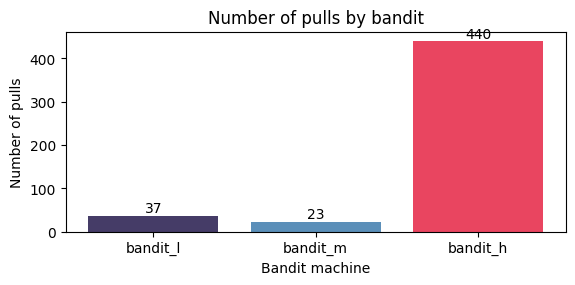

In [7]:
# Get all the data from the bandit machines
for bandit in bandits_greedy:
    bandit.get_data()


# Print the total reward
accuracy = round((total_reward_greedy/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_greedy} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_greedy)

## 2. Optimistic Initial Values

Optimistic Initial Values is a method that addresses the exploration-exploitation trade-off in Multi-Armed Bandit problems by setting initial estimates of rewards higher than their actual value, leading to more exploration and faster convergence to the optimal action.

**Experiment:**

In [8]:
# Creating the bandits for this experiment
bandits_oiv = [bandit_machine(name=n, probability=p, intial_mean=2, save_history=True)\
     for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500           # Number of total pulls allowed
total_reward_oiv = 0          # Total reward of the experiment
reward_history_oiv = [0]      # Reward history of the experiment

# Run the experiments
for i in range(n_experiments):
    # Choose the bandit based higher sample mean
    bandits_sample_mean = [m.sample_mean for m in bandits_oiv]
    j = np.argmax(bandits_sample_mean)
    
    # Pull the arm of the selected machine
    total_reward_oiv += bandits_oiv[j].pull()
    reward_history_oiv.append(total_reward_oiv)

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 6
          - Sample mean: 0.5
          - Cumulated reward: 1
          - Cumulated failures: 4
        


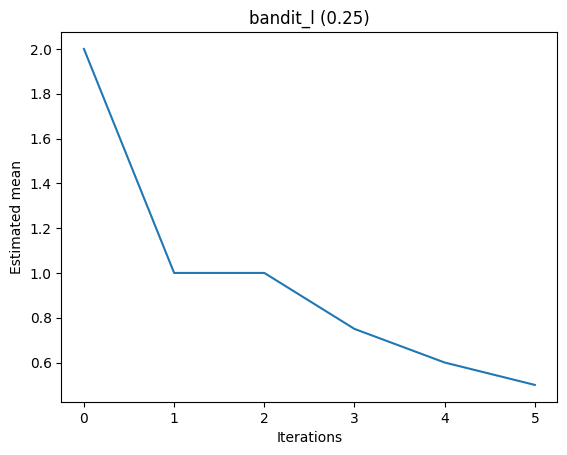


        [bandit_m (0.5)]
          - Arm pulled: 15
          - Sample mean: 0.5333333333333333
          - Cumulated reward: 6
          - Cumulated failures: 8
        


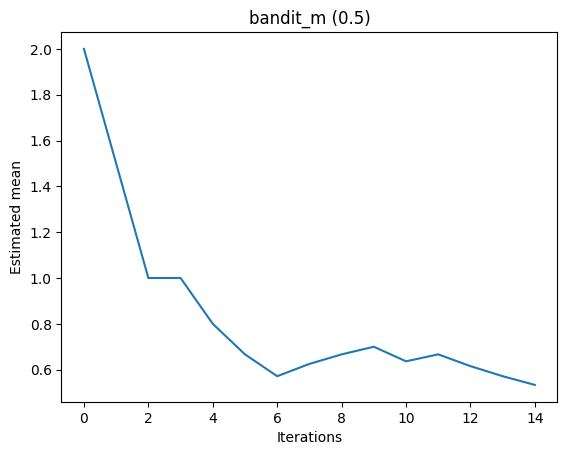


        [bandit_h (0.75)]
          - Arm pulled: 482
          - Sample mean: 0.7116182572614108
          - Cumulated reward: 341
          - Cumulated failures: 140
        


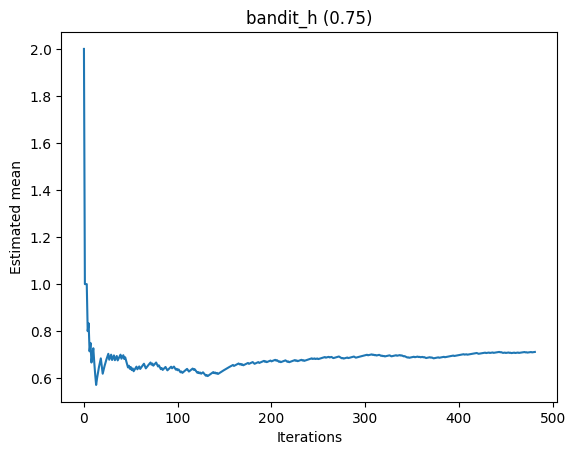

The total reward is 348 points in 500 pulls. (69.6%)


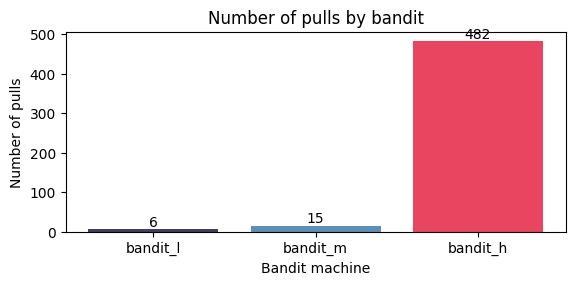

In [9]:
# Get all the data from the bandit machines
for bandit in bandits_oiv:
    bandit.get_data()

# Print the total reward
accuracy = round((total_reward_oiv/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_oiv} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_oiv)

## 3. Upper Confidence Bound (UCB1)

Upper Confidence Bound (UCB1) is a method that addresses the exploration-exploitation trade-off in Multi-Armed Bandit problems by choosing actions based on the estimated potential reward and the degree of uncertainty associated with that estimate, leading to an optimal balance between exploration and exploitation.

**Experiment:**

In [10]:
# UCB1 with Hoeffding's inequality condition
def apply_weight(x_mean, n_plays, n_samples):
    """
    Function to add weights based in Hoeffding's inequality
    """
    return x_mean + (2*log(n_plays)/n_samples)**0.5

In [11]:
# Creating the bandits for this experiment
bandits_ucb1 = [bandit_machine(name=n, probability=p, save_history=True)\
     for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500           # Number of total pulls allowed
total_reward_ucb1 = 0         # Total reward of the experiment
total_plays = 0               # Total plays counter
reward_history_ucb1 = [0]     # Reward history of the experiment

# Run the experiments
# Initialization
for j in range(len(bandits_ucb1)):
     x = bandits_ucb1[j].pull()
     total_plays += 1

# UCB1
for i in range(n_experiments):
    # Choose the bandit based higher sample mean
    bandits_sample_mean = [apply_weight(m.sample_mean, total_plays, m.n_pulls) for m in bandits_ucb1]
    j = np.argmax(bandits_sample_mean)
    
    # Pull the arm of the selected machine
    total_reward_ucb1 += bandits_ucb1[j].pull()
    reward_history_ucb1.append(total_reward_ucb1)

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 4
          - Sample mean: 0.0
          - Cumulated reward: 0
          - Cumulated failures: 4
        


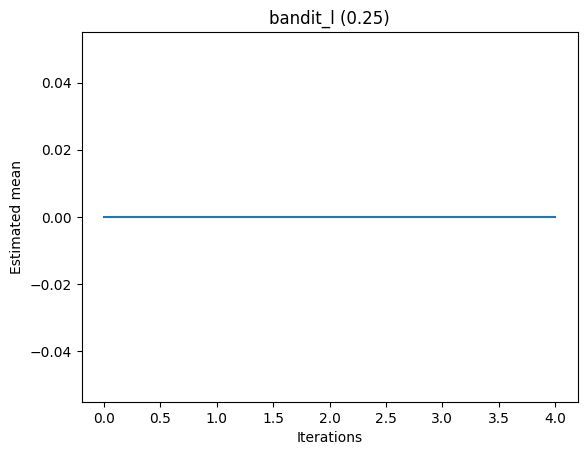


        [bandit_m (0.5)]
          - Arm pulled: 22
          - Sample mean: 0.5
          - Cumulated reward: 11
          - Cumulated failures: 11
        


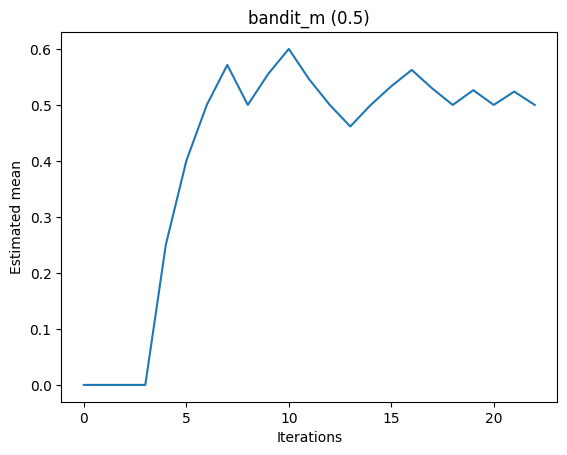


        [bandit_h (0.75)]
          - Arm pulled: 477
          - Sample mean: 0.7589098532494757
          - Cumulated reward: 362
          - Cumulated failures: 115
        


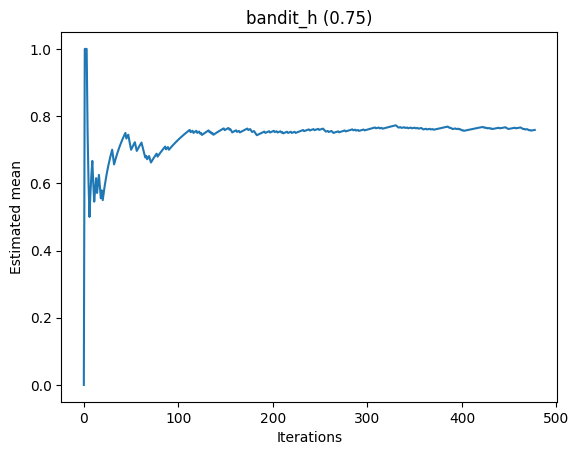

The total reward is 372 points in 500 pulls. (74.4%)


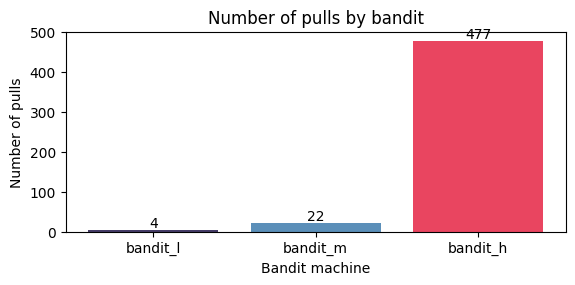

In [12]:
# Get all the data from the bandit machines
for bandit in bandits_ucb1:
    bandit.get_data()

# Print the total reward
accuracy = round((total_reward_ucb1/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_ucb1} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_ucb1)

## 4. Thompson Sampling (Bayesian Bandit)

Thompson Sampling is a method for solving Multi-Armed Bandit problems that addresses the exploration-exploitation trade-off by sampling actions from their posterior distributions, using Bayesian update rules to choose the action with the highest sample as the next action.

**Experiment:**

In [13]:
def sample_beta(n_rewards, n_failures):
    return np.random.beta(n_rewards, n_failures)

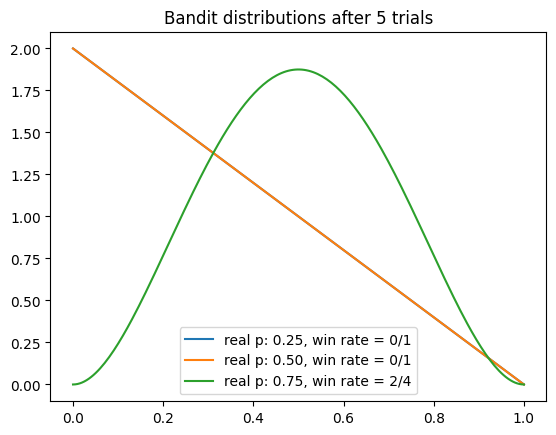

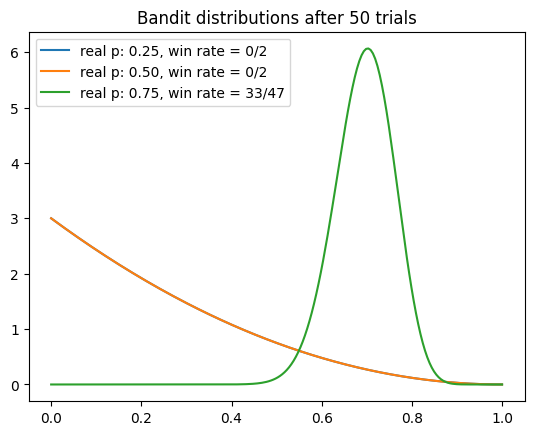

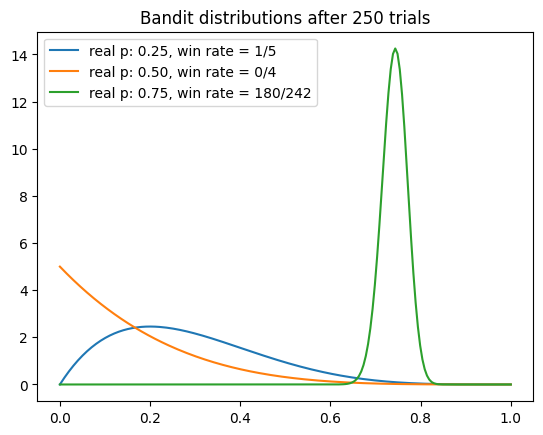

In [14]:
# Creating the bandits for this experiment
bandits_bayesian = [bandit_machine(name=n, probability=p, save_history=True)\
     for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500                # Number of total pulls allowed
total_reward_bayesian = 0          # Total reward of the experiment
plot_iteration = [5, 50, 250]      # Only to plot in the selected iterations
reward_history_bayesian = [0]      # Reward history of the experiment

# Run the experiments
for i in range(n_experiments):
    # Choose the bandit based higher sample mean
    bandits_sample_mean = [sample_beta(m.cumulated_reward+1, m.cumulated_failure+1) for m in bandits_bayesian]
    j = np.argmax(bandits_sample_mean)
    
    # Pull the arm of the selected machine
    total_reward_bayesian += bandits_bayesian[j].pull()
    reward_history_bayesian.append(total_reward_bayesian)

    # Plot distribution during iterations
    if i in plot_iteration:
     plot_bayesian_distributions(bandits_bayesian, i)

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 10
          - Sample mean: 0.2
          - Cumulated reward: 2
          - Cumulated failures: 8
        


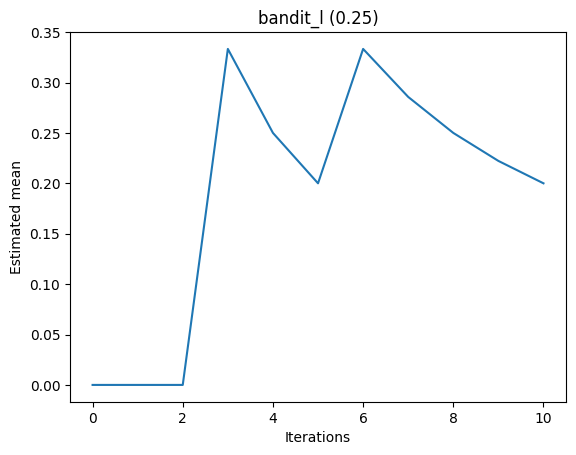


        [bandit_m (0.5)]
          - Arm pulled: 4
          - Sample mean: 0.0
          - Cumulated reward: 0
          - Cumulated failures: 4
        


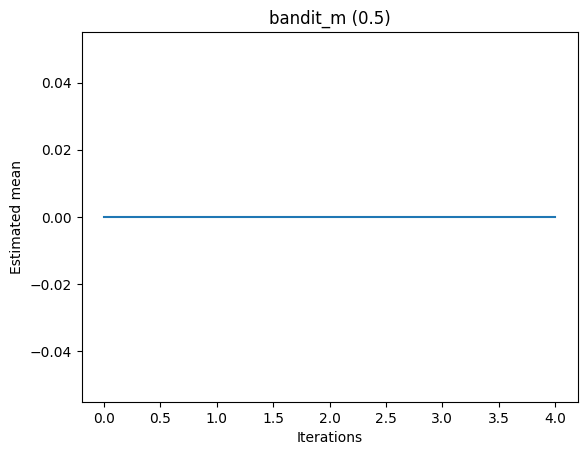


        [bandit_h (0.75)]
          - Arm pulled: 486
          - Sample mean: 0.7572016460905351
          - Cumulated reward: 368
          - Cumulated failures: 118
        


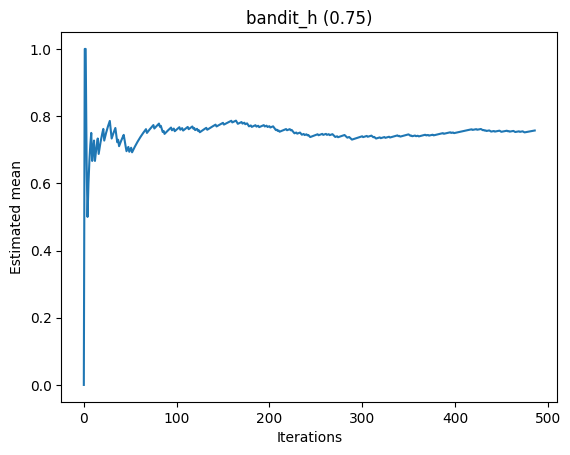

The total reward is 370 points in 500 pulls. (74.0%)


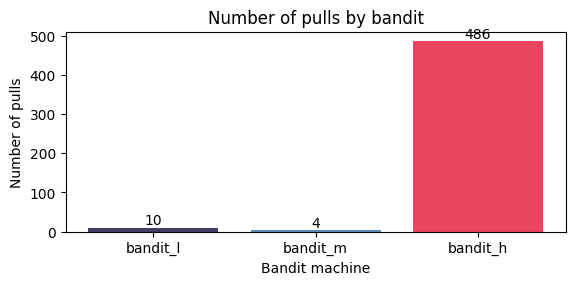

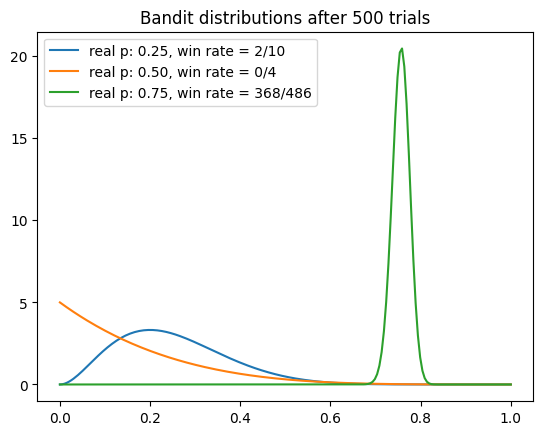

In [15]:
# Get all the data from the bandit machines
for bandit in bandits_bayesian:
    bandit.get_data()

# Print the total reward
accuracy = round((total_reward_bayesian/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_bayesian} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_bayesian)

plot_bayesian_distributions(bandits_bayesian, n_experiments)

## Model comparison


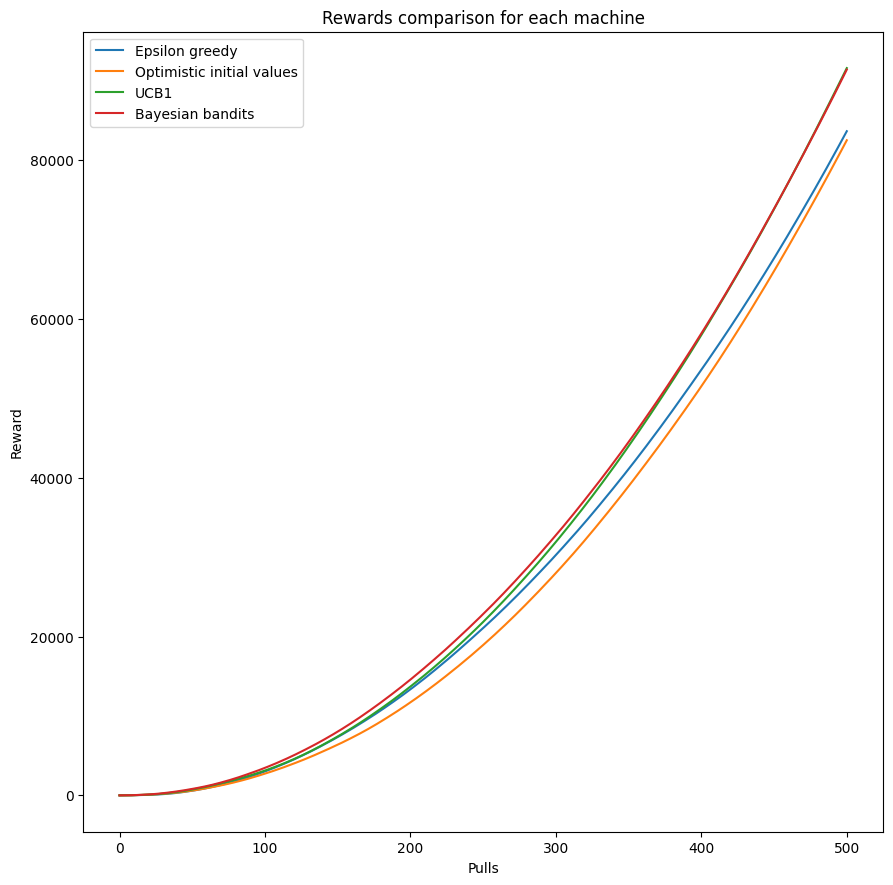

In [16]:
# History rewards
models = ['Epsilon greedy', 'Optimistic initial values', 'UCB1', 'Bayesian bandits']
rewards_history = [reward_history_greedy, reward_history_oiv, reward_history_ucb1, reward_history_bayesian]
plot_cumulative_rewards(models, rewards_history)